# Model Training 

Model Training Part of the Project

Based on the complexity and high-dimensionality of the data, the following models are chosen:
- XGBoost
- Random Forest
- Neural Network

These models were chosen because they don't have some strict assumptions to get a meaningful result,
can capture underlying patterns very well. Furthermore, might apply Principal Component Analysis, Cross-Validation, & Hyper-parameter tuning to the model, probably using optuna

### General Functions

Add a common ingest data function that reads splits, and returns X_train, y_train & X_test, y_test cols

## XGBoost

In [1]:
import pandas as pd

#Load pre-split data
train_df = pd.read_parquet("../data/splits/train.parquet")
test_df = pd.read_parquet("../data/splits/test.parquet")

#Separate features and target
X_train, y_train = train_df.drop(columns=["rating"]), train_df["rating"]
X_test, y_test = test_df.drop(columns=["rating"]), test_df["rating"]


In [2]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from xgboost.callback import EarlyStopping
import numpy as np
import optuna

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        
        # Required parameters for xgb.train
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "auto"
    }
    
    # Separate parameter for num_boost_round
    num_boost_round = trial.suggest_int("n_estimators", 200, 2000)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        D_train = xgb.DMatrix(X_tr, y_tr)
        D_valid = xgb.DMatrix(X_val, y_val)
        
        model = xgb.train(
            params=params,
            dtrain=D_train,
            num_boost_round=num_boost_round,
            evals=[(D_train, "Train"), (D_valid, "Valid")],
            callbacks=[EarlyStopping(rounds=50, metric_name='rmse', data_name='Valid')],
            verbose_eval=False
        )

        preds = model.predict(D_valid)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)
        
        # Report progress to Optuna
        trial.report(rmse, len(rmse_scores) - 1)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(rmse_scores)

/opt/homebrew/Caskroom/miniconda/base/envs/COP4283_Project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import xgboost as xgb
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)


print("Best RMSE(CV):", study.best_value)
print("Best hyperparameters:", study.best_params)


# Train the best model on the full training set
print("======Training the best model=====")
best_params = study.best_trial.params
num_boost_round = best_params.pop('n_estimators')
best_params.update({
    "objective":"reg:squarederror",
    "eval_metric":"rmse",
    "tree_method":"auto"
})
D_full_train = xgb.DMatrix(X_train,y_train)

best_model = xgb.train(
    params = best_params,
    dtrain=D_full_train,
    num_boost_round=num_boost_round,
)
print("\n====Predicting on the test set====")
D_test = xgb.DMatrix(X_test)
test_preds = best_model.predict(D_test)

[I 2025-11-21 14:33:50,488] A new study created in memory with name: no-name-c0ecc96c-33db-4168-b1f3-fa9065156635
[I 2025-11-21 14:33:53,252] Trial 0 finished with value: 0.4627245288945975 and parameters: {'learning_rate': 0.2823915603624678, 'max_depth': 6, 'subsample': 0.5868359039934852, 'colsample_bytree': 0.5787615124076158, 'reg_lambda': 7.421862788050186, 'reg_alpha': 0.0803812034435212, 'n_estimators': 815}. Best is trial 0 with value: 0.4627245288945975.
[I 2025-11-21 14:33:56,764] Trial 1 finished with value: 0.4531491500699782 and parameters: {'learning_rate': 0.1503480100586077, 'max_depth': 5, 'subsample': 0.7832912411085557, 'colsample_bytree': 0.7348763736496697, 'reg_lambda': 0.17781659192238286, 'reg_alpha': 0.010661327141355727, 'n_estimators': 1729}. Best is trial 1 with value: 0.4531491500699782.
[I 2025-11-21 14:34:03,454] Trial 2 finished with value: 0.43499813023526873 and parameters: {'learning_rate': 0.09182026288057211, 'max_depth': 8, 'subsample': 0.74098314

Best RMSE(CV): 0.429084550057038
Best hyperparameters: {'learning_rate': 0.011963954233762245, 'max_depth': 9, 'subsample': 0.6247270373256645, 'colsample_bytree': 0.8013113312435928, 'reg_lambda': 0.4394789206235467, 'reg_alpha': 0.007574256166381663, 'n_estimators': 1431}
======Training the best model=====
====Predicting on the test set====


In [5]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, test_preds)
rmse = mse ** 0.5
r2 = r2_score(y_test, test_preds)

print(f"Final RMSE: {rmse}")
print(f"R² Score: {r2}")


Final RMSE: 0.4226756750941998
R² Score: 0.8110188569755059


### Diagnostic Plots

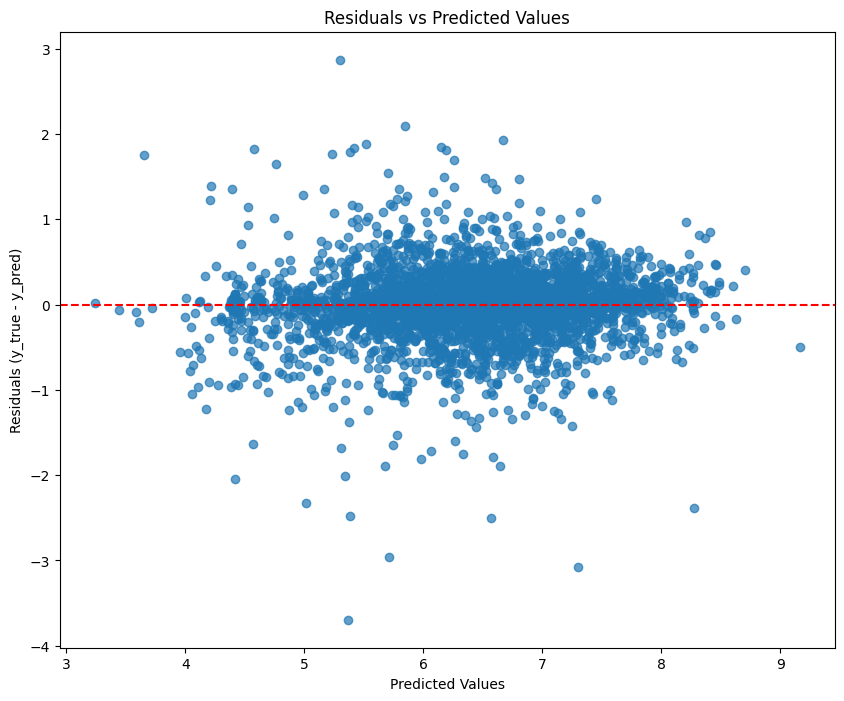

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

residuals = y_test - test_preds


plt.figure(figsize=(10,8))
plt.scatter(test_preds, residuals, alpha=.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values")
plt.show()

### SHAPE Value

## Random Forest

In [ ]:
import pandas as pd
